# Pricing Options with the Binomial Model

The binomial model gives a good approximation of path-dependent asset prices in the Black-Scholes framework. It assumes that in each step (a short period of time) the price can either go up or down.
The coefficients of moving up and down are constant ($u$ and $d$) and so is the $p$ probability of moving upwards. Moreover, this probability is the risk neutral probability, which means that the mean return $r$ calculated from the binomial model equals the risk free, expected rate of return of the underlying asset. This constant rate of return and the variance is assumed to be proportional to the time period, based on the assumption that log returns are iid normal variables.

Having 2 restrictions (return during $\Delta t$ is $r \Delta t$ while variance is $\sigma^2 \Delta t$) and 3 free variables ($u$, $d$, $p$), one further assumption is needed. One can assume, for instance, that the risk neutral probability is $\frac{1}{2}$ or that $u=\frac{1}{d}$. The latter is called the _Cox-Ross-Rubinstein model_.

I give a function to calculate the price of a European option, given the spot price $S$, the strike price $K$, the time horizon $T$, the number of periods $n$, the risk free rate of return $r$ and the standard deviation $\sigma$.
I give implementations for both variants: the _CRR_ model and the $p=\frac{1}{2}$ case. The type of the option i.e. call or put is also a parameter.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from scipy.ndimage.interpolation import shift

The following $\texttt{create}\_\texttt{binomial}\_\texttt{tree}$ function creates a binomial tree from the underlying asset's price. Although storing the whole tree is common practice I find it more convenient to only keep the last level.

Reconstructing previous nodes is, of course, possible.

In [2]:
def create_binomial_tree(u, d, call, n, S, K):
    '''
    Returns:
        - the n-th step of a geometric binomial tree from the spot price of the underlying asset
        - the value of the derivative /call or put/ in each node of this n-th step
    ...
    u ... "up" coefficient
    d ... "down" coefficient
    call ... Boolean, True if call, False if put
    n ... number of steps in the binomial model
    S ... spot price
    K ... strike price
    '''
    # Defining a variable to deal with call and put options
    X = 1 if call else -1
    
    # Binomial tree from the spot price. 
    spot = np.zeros(n+1)
    spot[0] = S # root of the tree is the current spot price
    for i in range(n):
        last = spot[i]
        spot *= u # multiply each node by u
        spot[i+1] = last *d # add a new node by multiplying the last node of the previous level by d

    # Derivative from the underlying: value of call or put
    g = np.maximum(0, X*(spot - K))
    
    # Return the n-step spot prices, the value of the derivative at these nodes, and an indicator of the type of the derivative 
    return spot, g, X

__European options__ are the simplest, so-called vanilla options. They have a specific maturity date and the option can only be exercised then. Therefore, European options are not path-dependent, that is, their value only depends on the price at maturity. It makes sense, however, to model the price in-between the start and maturity date in order to compare to American options.

Here, the $\texttt{calculate}\_\texttt{european}$ function works with the binomial tree of the derivative. In every node, we calculate the expected discounted value of the 2 children nodes until we get to the root. The value of the option is this discounted expected value at the root. The discount factor is $e^{-r \Delta t}$.

In [3]:
def calculate_european(u, d, p, call, n, S, K, df):
    '''
    Calculates the value of a european vanilla call or put option.
    ...
    u ... "up" coefficient
    d ... "down" coefficient
    p ... risk neutral probability of moving "up"
    call ... Boolean, True if call, False if put
    n ... number of steps in the binomial model
    S ... spot price of the underlying asset
    K ... strike price
    df ... risk free discount factor
    '''

    # spot prices and derivative values at maturity, calculated by the binomial tree function
    spot, g, _ = create_binomial_tree(u, d, call, n, S, K)

    # Calculating the present value of the derivative, discounting the expected value step-by-step, backwards from maturity
    for _ in range(n): # repeat calculating expected value and discounting until we get to the root -- n steps needed
        lag = shift(g, -1) 
        g = p * g + (1-p) * lag # expected value at each node
        g *= df # discounting this expected value
    
    return g[0] # the first element in the vector is the value at the root


Now, define some useful unit tests for pricing the European options. If both $u$ and $d$ are 1, therefore the price does not vary over time, the value of the option must be the intrinsic value. For in-the-money (ITM) options, this is a positive number, for at-the-money (ATM) or out-of-the-money (OTM) options, it is 0.

In [4]:
import unittest

class EuropeanOptionTests(unittest.TestCase):

    def test_EuropeanCallIsConstantForUandDOne(self):
        self.assertAlmostEqual(calculate_european(u=1, d=1, p=0.7, call=True, n=1000, S=1300, K=1200, df=1), (1300-1200))
        
    def test_EuropeanPutIsZeroForUandDOne(self):
        self.assertAlmostEqual(calculate_european(u=1, d=1, p=0.7, call=False, n=1000, S=1300, K=1200, df=1), 0)

__American options__ differ from European in the sense that they can be exercised at any time (or at specific times) before maturity. It is therefore essential to know the price of the undelying at these specific moments. The binomial model is a great tool to predict the path of the price.

The $\texttt{calculate}\_\texttt{american}$ function works similarly than the previous one, except that if at a node the intrinsic value of the derivative is greater than the discounted expected value of the children nodes, the value of this node will be the intrinsic value.

It is clear that American options are more favourable for the long client, thus they must be worth at least as much as European options. 

In [5]:
def calculate_american(u, d, p, call, n, S, K, df):
    '''
    Calculates the value of an american call or put option.
    ...
    u ... "up" coefficient
    d ... "down" coefficient
    p ... risk neutral probability of moving "up"
    call ... Boolean, True if call, False if put
    n ... number of steps in the binomial model
    S ... spot price of the underlying asset
    K ... strike price
    df ... risk free discount factor
    '''

    # spot prices, derivative values at maturity, and call/put indicator calculated by the binomial tree function
    spot, g, X = create_binomial_tree(u, d, call, n, S, K)
    
    # Calculating the present value of the derivative, discounting the expected value step-by-step, backwards from maturity
    for j in range(n):# repeat calculating expected value and discounting until we get to the root -- n steps needed
        lag = shift(g,-1)
        x = p * g + (1-p) * lag # expected value at each node
        x *= df # discounting this expected value
        spot /= u # previous level derivative values are needed in the American option
        derivative = np.maximum(0, X*(spot - K)) # calculating the value of the derivative in previous level nodes
        g = np.maximum(derivative, x) # the actual value is the higher of the discounted expected value and the current value
    
    return g[0] # the first element in the vector is the value at the root

Unit tests for the American options: if both $u$ and $d$ are 1, time does not play a role, so the result is exactly the same as in the European case.

In [6]:
class AmericanOptionTests(unittest.TestCase):

    def test_AmericanCallIsConstantForUandDOne(self):
        self.assertAlmostEqual(calculate_american(u=1, d=1, p=0.7, call=True, n=1000, S=1300, K=1200, df=1), (1300-1200))
        
    def test_AmericanPutIsZeroForUandDOne(self):
        self.assertAlmostEqual(calculate_american(u=1, d=1, p=0.7, call=False, n=1000, S=1300, K=1200, df=1), 0)

As mentioned earlier, we need a further assumption to calculate $u$, $d$ and $p$ in the binomial model. There are several versions, the two most famous are the CRR model where $u = \frac{1}{d}$ and the symmetric case when $p = \frac{1}{2}$.

The $\texttt{option}\_\texttt{price}$ function calculates the option price based on the model. Specifications include the setting of parameters, the call/put type and the European/American case.

In [7]:
def option_price(S, K, T, n, r, sigma, call = True, model ='crr', continent = 'european'):
    '''
    Calculates the price of a European/American call or put option with the binomial model.
    Default is European call option in the CRR framework.
    ...
    S ... spot price of the underlying asset
    K ... strike price
    T ... time to maturity
    n ... number of steps in the binomial model
    r ... risk free "expected" rate of log return
    sigma ... standard deviation of the price
    call ... Boolean, True if call, False if put
    model ... 'crr' means that u = 1/d
              'equal' means that p = 0.5
    continent ... 'european' or 'american'
    '''
    
    dt = T/n # time step
    df = math.exp(-r * dt) # discount factor
    
    # Set the parameters according to the model specification
    if model == 'crr':
        # "Up" coefficient
        u = math.exp(sigma * math.sqrt(dt))
        # "Down" coefficient
        d = 1/u
        # Risk-neutral probability of moving "up"
        p = (1/df - d)/(u - d)
    
    elif model == 'equal':
        alpha = r - sigma**2 / 2
        alpha *= dt
        # "Up" coefficient
        u = math.exp(alpha + sigma * dt**0.5)
        # "Down" coefficient
        d = math.exp(alpha - sigma * dt**0.5)
        # Risk-neutral probability of moving "up"
        p = 0.5
    
    else: # only 'crr' and 'equal' are valid models
        raise ValueError(model + " is not a valid model")
    
    if continent == 'european': # calculate European derivative price
        return calculate_european(u, d, p, call, n, S, K, df)
    
    elif continent == 'american': # calculate American derivative price
        return calculate_american(u, d, p, call, n, S, K, df)

    else: # only 'european' and 'american' options can be calculated
        raise ValueError(continent + " is not a valid option type")

In [8]:
class OptionPricingTests(unittest.TestCase):

    def test_EuropeanCallIsPricedCorrectly_BasedOnKnownResults(self):
        # Compare result with a known example for this given input
        self.assertAlmostEqual(option_price(100,100,1,1,0.04,0.2, model='crr', call = True), 11.732, 3)


## Numerical Examples

We set default values for some parameters. The strike price is arbitrary, and the half range of spot prices is equal to that. Note that only the relative difference between $S$ and $K$ counts, so this arbitrary choice is justified.

In [9]:
default_K = 50
default_half_range = 50
default_step_in_range = 10

spots = np.arange(default_K - default_half_range, default_K + default_half_range, default_step_in_range)

Usually, $r$ and $\sigma$ are historical values for the underlying asset or the economy in question. Here we don't have a specific asset in mind, so we set sensible but arbitrary values, in line with literature.

In [10]:
default_r = 0.04
default_sigma = 0.2

default_number_of_steps = 100

Define vectorizer function for calculating option prices for a range of _spot_ values.

In [11]:
def price_option_against_spots(spots, T, continent, call):
    return np.vectorize(
        lambda spot, _T=T, _continent=continent, _call=call: # Bind these parameters at lambda creation time, not runtime
            option_price(S=spot, K=default_K, T=_T, n=default_number_of_steps, r=default_r, sigma=default_sigma,
                         call=_call, continent=_continent)
    ) (spots)

Now let's display some plots.

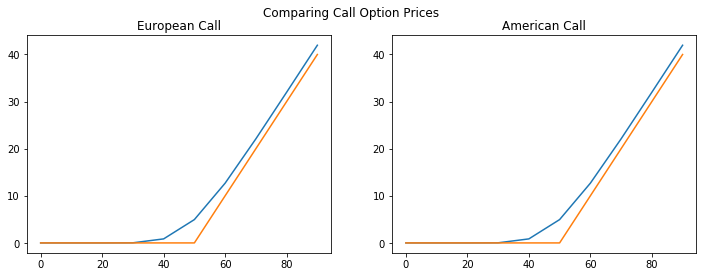

In [12]:
[european_call_data, american_call_data] = [price_option_against_spots(spots, T=1, continent=_continent, call=True)
                                            for _continent in ['european', 'american']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Comparing Call Option Prices')

ax1.set_title('European Call')
ax1.plot(spots, european_call_data)
ax1.plot(spots, np.maximum(0, spots - default_K))

ax2.set_title('American Call')
ax2.plot(spots, american_call_data)
ax2.plot(spots, np.maximum(0, spots - default_K))

plt.show()

They look exactly the same, and in this parameter setting, it is probably the case. Note, though, that there are cases when American calls are worth more than European ones. 

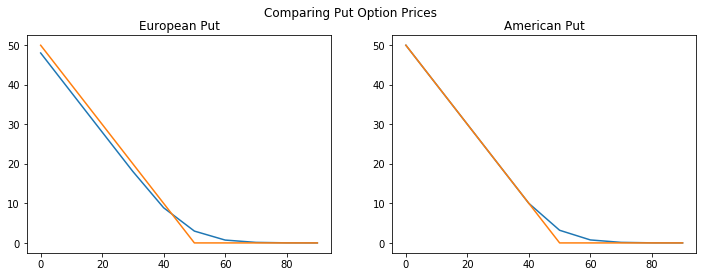

In [13]:
[european_put_data, american_put_data] = [price_option_against_spots(spots, T=1, continent=_continent, call=False)
                                          for _continent in ['european', 'american']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Comparing Put Option Prices')

ax1.set_title('European Put')
ax1.plot(spots, european_put_data)
ax1.plot(spots, np.maximum(0, default_K - spots))

ax2.set_title('American Put')
ax2.plot(spots, american_put_data)
ax2.plot(spots, np.maximum(0, default_K - spots))

plt.show()

On the other hand, it is interesting to see that while a European put's time value can be negative, an American put is worth at least its intrinsic value.

Firstly, let us compare the European call and put. Spot prices have a lower bound (0), but in theory, can go to infinity. So we can see that the distribution cannot be symmetric. That is why, in theory, a call can be worth infinity, while a put is at most about the strike price. So when we evaluate a deeply ITM European put, we can expect that its price will probably go up in the future, so it will not be worth as much as it would now. This is why the time value is negative, as seen in the graph.

In comparison, an American put can be exercised when it is deeply ITM. So if we expect that price will go up in the future, we exercise the option now, instead. This is why the time value is 0 for deeply ITM American options.

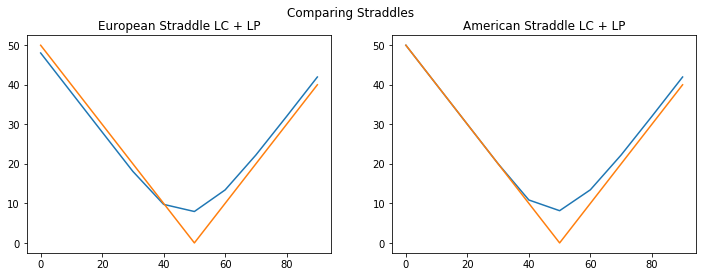

In [14]:
european_straddle_data = european_put_data + european_call_data
american_straddle_data = american_put_data + american_call_data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Comparing Straddles')

ax1.set_title('European Straddle LC + LP')
ax1.plot(spots, european_straddle_data)
ax1.plot(spots, np.abs(default_K - spots))

ax2.set_title('American Straddle LC + LP')
ax2.plot(spots, american_straddle_data)
ax2.plot(spots, np.abs(default_K - spots))

plt.show()

The straddle is just the sum of a long call and a long put, here with a same exercise price and maturity date. It is also known as "buying the volatility" as it yields the most when the price is far from the exercise price.

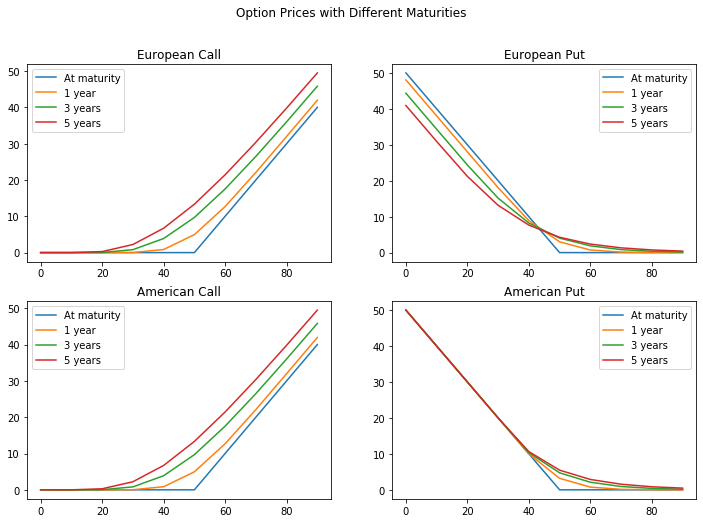

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

fig.suptitle("Option Prices with Different Maturities")

datas = [[price_option_against_spots(spots, T=_T, continent=_continent, call=_call)
    for _T in [1, 3, 5]]
        for (_continent, _call) in [('european', True), ('european', False), ('american', True), ('american', False)]]

for (ax, title, positive), data in zip([(ax1, "European Call", True), (ax2, "European Put", False),
                                        (ax3, "American Call", True), (ax4, "American Put", False)], datas):
    ax.set_title(title)
    ax.plot(spots, np.maximum(0, spots - default_K if positive else default_K - spots), label='At maturity')
    ax.plot(spots, data[0], label='1 year')
    ax.plot(spots, data[1], label='3 years')
    ax.plot(spots, data[2], label='5 years')
    ax.legend()

plt.show()

Over time, the value of an option converges to the intrinsic value as time value goes to 0. 

It is quite surprising to see, however, that in the European put case, all graphs seem to intersect the "at maturity" line at the same, seemingly random point.

In [16]:
# Unit test runner
unittest.main(argv=[''], verbosity=2, exit=False)

test_AmericanCallIsConstantForUandDOne (__main__.AmericanOptionTests) ... ok
test_AmericanPutIsZeroForUandDOne (__main__.AmericanOptionTests) ... ok
test_EuropeanCallIsConstantForUandDOne (__main__.EuropeanOptionTests) ... ok
test_EuropeanPutIsZeroForUandDOne (__main__.EuropeanOptionTests) ... ok
test_EuropeanCallIsPricedCorrectly_BasedOnKnownResults (__main__.OptionPricingTests) ... ok

----------------------------------------------------------------------
Ran 5 tests in 1.427s

OK


These are the tests defined earlier. If all of them return "ok", the functions work properly.